In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

from src.dataset.dataset import FurnitureImageDataset
from src.behavior import get_actor
from src.common.files import get_processed_paths
from src.common.control import ControlMode
from src.dataset.normalizer import LinearNormalizer
import torch
from pathlib import Path
from tqdm import trange, tqdm
from src.common.pytorch_util import dict_apply
from omegaconf import OmegaConf, DictConfig
from src.visualization.render_mp4 import data_to_video, create_mp4_jupyter
from wandb import Api
import cv2
import numpy as np

from torch.utils.data import DataLoader


api = Api()

In [3]:
def convert_state_dict(state_dict):
    if not any(k.startswith("encoder1.0") for k in state_dict.keys()) and not any(
        k.startswith("encoder1.model.nets.3") for k in state_dict.keys()
    ):
        print("Dict already in the correct format")
        return

    # Change all instances of "encoder1.0" to "encoder1" and "encoder2.0" to "encoder2"
    # and all instances of "encoder1.1" to encoder1_proj and "encoder2.1" to "encoder2_proj"
    for k in list(state_dict.keys()):
        if k.startswith("encoder1.0"):
            new_k = k.replace("encoder1.0", "encoder1")
            state_dict[new_k] = state_dict.pop(k)
        elif k.startswith("encoder2.0"):
            new_k = k.replace("encoder2.0", "encoder2")
            state_dict[new_k] = state_dict.pop(k)
        elif k.startswith("encoder1.1"):
            new_k = k.replace("encoder1.1", "encoder1_proj")
            state_dict[new_k] = state_dict.pop(k)
        elif k.startswith("encoder2.1"):
            new_k = k.replace("encoder2.1", "encoder2_proj")
            state_dict[new_k] = state_dict.pop(k)

    return state_dict

In [4]:
run = api.run("sweeps/runs/brsbq5d2")
cfg = OmegaConf.create(run.config)

In [5]:
[file for file in run.files() if file.name.endswith(".pt")]

[<File models/honest-sweep-31/actor_chkpt_best_test_loss.pt (application/vnd.snesdev-page-table) 1.1GiB>]

In [6]:
model_wts = (
    [file for file in run.files() if file.name.endswith(".pt")][0]
    .download(replace=False, exist_ok=True)
    .name
)

In [7]:
file_paths = get_processed_paths(
    environment="sim",
    task="one_leg",
    demo_outcome="success",
    demo_source="teleop",
    randomness="low",
)

normalizer = LinearNormalizer(
    control_mode=ControlMode.delta,
)

# Make the dataset
dataset = FurnitureImageDataset(
    dataset_paths=file_paths,
    action_horizon=8,
    pred_horizon=32,
    augment_image=False,
    obs_horizon=1,
    control_mode=ControlMode.delta,
    data_subset=None,
    normalizer=normalizer,
)

Found the following paths:
    /data/scratch/ankile/furniture-data/processed/sim/one_leg/teleop/low/success.zarr


Loading zarr files:   0%|          | 0/1 [00:00<?, ?it/s]


























































Loading zarr files: 100%|██████████| 1/1 [00:06<00:00,  6.40s/it]


Loading dataset of 50 episodes


In [8]:
actor = get_actor(
    device="cuda",
    normalizer=normalizer.get_copy(),
    config=cfg,
)

actor.load_state_dict(convert_state_dict(torch.load(model_wts)))

/data/scratch/ankile/miniconda3/envs/rlgpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using inference steps: 16
Total parameters: 304.09M
normalizer: 0.00M parameters
encoder1: 11.19M parameters
encoder2: 11.19M parameters
encoder1_proj: 0.03M parameters
encoder2_proj: 0.03M parameters
model: 281.64M parameters
loss_fn: 0.00M parameters


<All keys matched successfully>

In [9]:
f"Number of episodes: {len(dataset.episode_ends)}, number of images: {len(dataset)}, final episode_end: {dataset.episode_ends[-1]}"

'Number of episodes: 50, number of images: 27820, final episode_end: 29020'

In [10]:
# Find the end of the first episode
ep_idx = 0
ep_start = dataset.episode_ends[ep_idx - 1] if ep_idx > 0 else 0
ep_end = dataset.episode_ends[ep_idx]

# Find the index of the insertion action
insertion_skill_idx = 3

# Find the index of the 3rd time skills is 1
insertion_idx = np.where(dataset.skills[ep_start:ep_end] == 1)[0][insertion_skill_idx]

ep_start, ep_end, insertion_idx

(0, 535, 244)

In [11]:
dataset.skills.sum()

32

## Look at some example predicted actions

In [12]:
timestep = ep_start + 10

batch = dataset[timestep]

n_samples = 1000
actor.inference_steps = 4

with torch.no_grad():
    batch = dict_apply(batch, lambda x: x.to("cuda", non_blocking=True).unsqueeze(0))
    nobs = actor._training_obs(batch)

    # Repeat the nobs n_samples times to get a good average
    nobs = nobs.repeat(n_samples, 1)

    # Predict normalized action
    naction = actor._normalized_action(nobs)

    # unnormalize action
    # (B, pred_horizon, action_dim)
    actions = actor.normalizer(naction, "action", forward=False)[:, :8].cpu()

In [13]:
actions.shape

torch.Size([1000, 8, 10])

In [14]:
# Calculate the mean and std of the actions (look at only the first action)
mean = actions.mean(dim=0)[0]
std = actions.std(dim=0)[0]

print(mean.shape)

print(mean)
print(std)
print(std / mean)

torch.Size([10])
tensor([-0.0112, -0.0243, -0.0184,  0.9625,  0.2625,  0.0217, -0.2632,  0.9618,
         0.0426, -0.9982])
tensor([0.0009, 0.0006, 0.0006, 0.0014, 0.0067, 0.0033, 0.0066, 0.0013, 0.0035,
        0.0026])
tensor([-0.0830, -0.0238, -0.0304,  0.0014,  0.0256,  0.1536, -0.0253,  0.0014,
         0.0815, -0.0026])


Text(0.5, 0.98, 'Histogram of the action idx 0 over 1000 samples with 4\ninference steps at timestep 10 at episode 0')

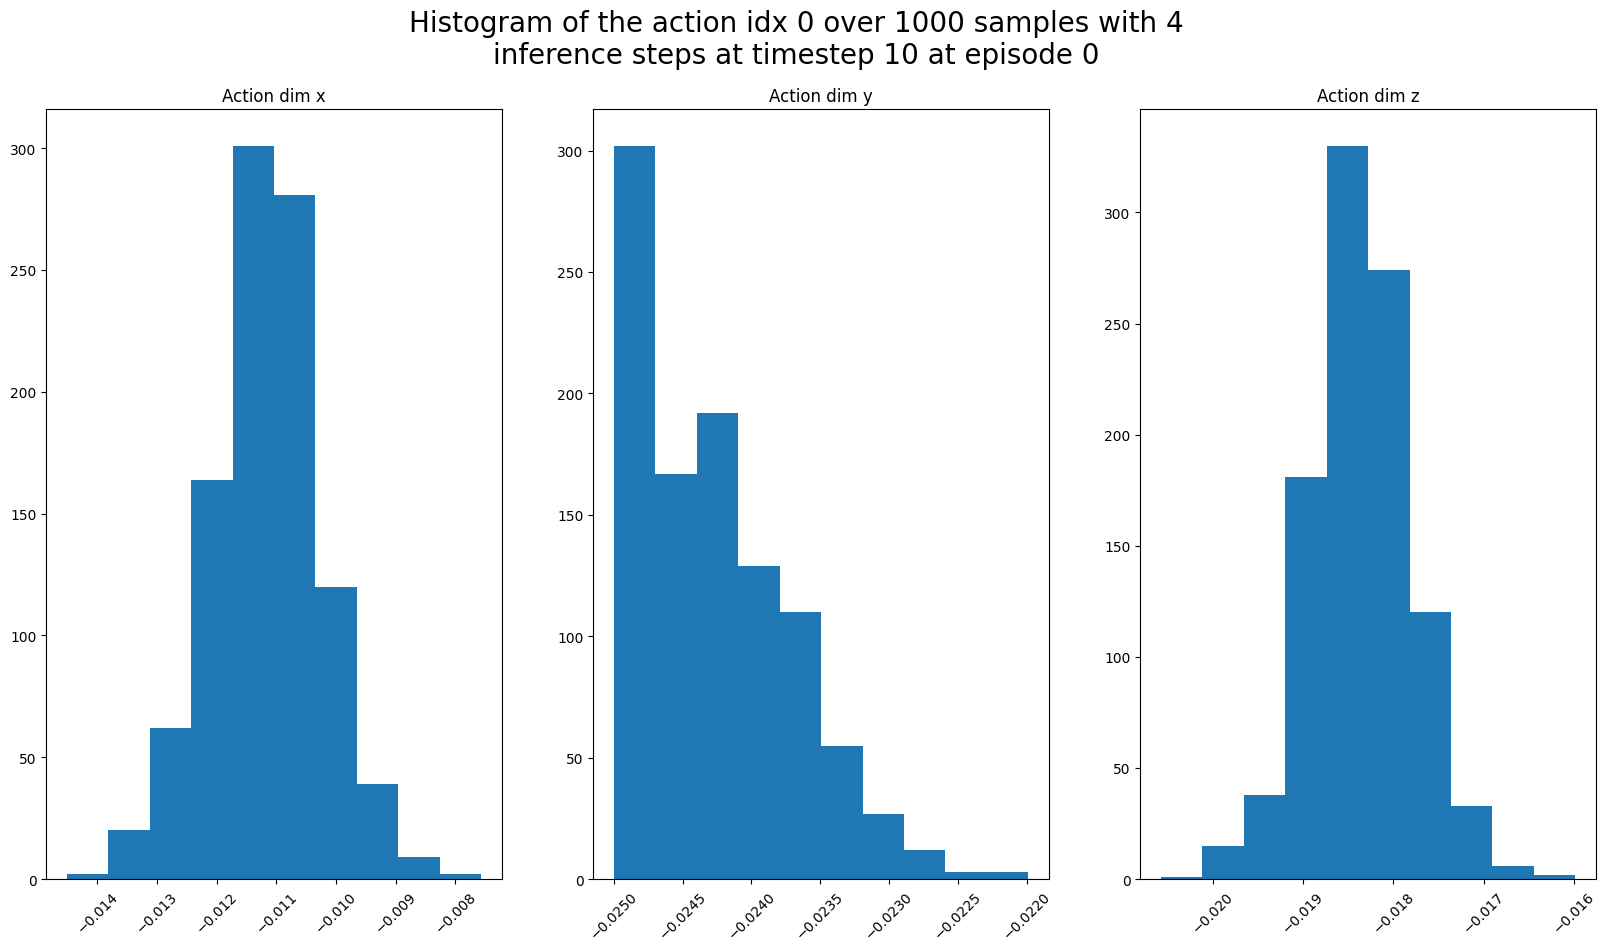

In [15]:
# Show a histogram over the 10 samples for each of the 8 action dimensions
# Control what action in the prediction sequence to look at [0, 7]
histogram_action_index = 0

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
for i, coord in enumerate(["x", "y", "z"]):
    ax = axs[i]
    ax.hist(actions[:, histogram_action_index, i].cpu().numpy())
    ax.set_title(f"Action dim {coord}")

    # Set the x-axis tixck labels at an angle
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

fig.suptitle(
    f"Histogram of the action idx {histogram_action_index} over {n_samples} samples with {actor.inference_steps}\ninference steps at timestep {timestep} at episode {ep_idx}",
    fontsize=20,
)

## Look at the coefficient of variation of the predicted actions across an episode

In [24]:
def calculate_epi_stats(
    dataset, actor, ep_start, ep_end, action_batch=8, samples=100, batch_size=100
):
    means = []
    stds = []
    cvs = []
    actuals = []

    for i in trange(ep_start, ep_end, batch_size * action_batch):
        end_idx = min(i + batch_size * action_batch, ep_end)

        # Manually make a batch
        batch = {
            k: torch.stack([dataset[i][k] for i in range(i, end_idx, action_batch)])
            for k in dataset[0].keys()
        }

        with torch.no_grad():
            batch = dict_apply(batch, lambda x: x.to("cuda", non_blocking=True))

            actual_action = actor.normalizer(
                batch["action"][:, :8].reshape(-1, 10),
                "action",
                forward=False,
            ).cpu()

            # Store the actual actions
            actuals.extend(actual_action)

            # Shape of nobs is (B, obs_dim)
            nobs = actor._training_obs(batch)

            # Repeat the nobs 100 times for each sample in the batch
            # Shape of nobs is now (B, 1, obs_dim)
            nobs = nobs.unsqueeze(1)

            # Repeat the nobs {samples} times to get a good average
            # Shape of nobs is now (B, samples, obs_dim)
            nobs = nobs.repeat(1, samples, 1)

            # Reshape to (B * samples, obs_dim)
            nobs = nobs.view(-1, nobs.shape[-1])

            # Predict normalized action
            # Shape of naction is (B * samples, pred_horizon, action_dim)
            naction = actor._normalized_action(nobs)

            # Reshape to (B, samples, pred_horizon, action_dim)
            naction = naction.view(-1, samples, naction.shape[-2], naction.shape[-1])

            # unnormalize action
            # (B, samples, pred_horizon, action_dim)
            actions = actor.normalizer(naction, "action", forward=False)[:, :, :8].cpu()

        # Calculate the mean and std of the actions over the samples dimension (axis=1)

        mean = actions.mean(dim=1).reshape(-1, 10)
        std = actions.std(dim=1).reshape(-1, 10)

        # Add to the list
        means.extend(mean)
        stds.extend(std)
        cvs.extend(std / mean)

    means = torch.stack(means)[: ep_end - ep_start]
    stds = torch.stack(stds)[: ep_end - ep_start]
    cvs = torch.stack(cvs)[: ep_end - ep_start]
    actuals = torch.stack(actuals)[: ep_end - ep_start]

    return means, stds, cvs, actuals


means, stds, cvs, actuals = calculate_epi_stats(
    dataset, actor, ep_start, ep_end, action_batch=8, samples=100, batch_size=100
)

100%|██████████| 1/1 [00:04<00:00,  4.60s/it]


In [17]:
means.shape, stds.shape, cvs.shape, actuals.shape

(torch.Size([535, 10]),
 torch.Size([535, 10]),
 torch.Size([535, 10]),
 torch.Size([535, 10]))

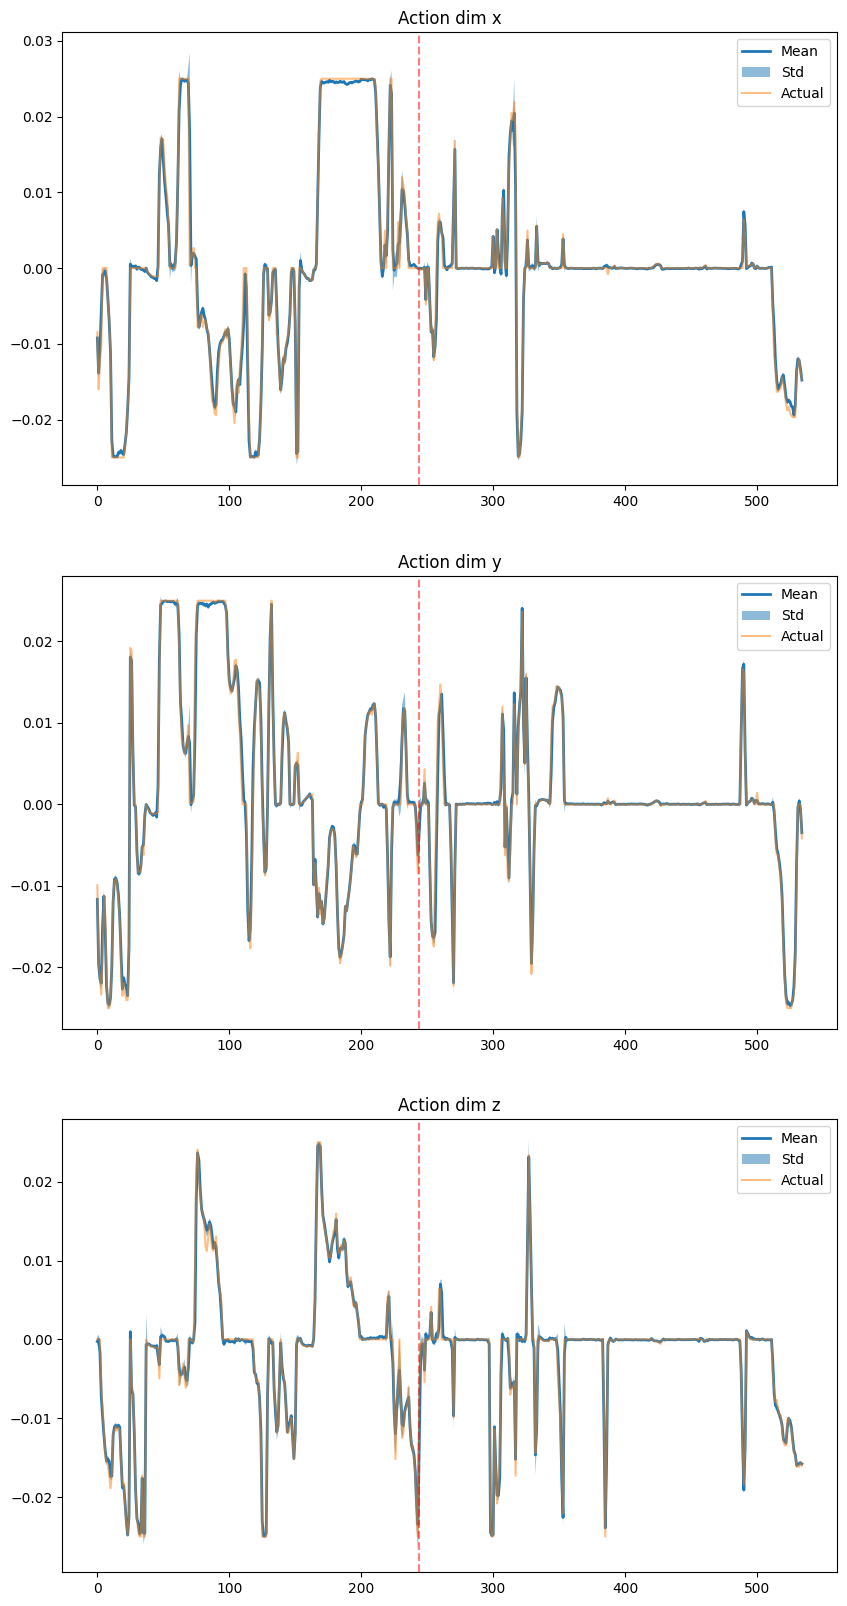

In [23]:
# Do the same as above but focus on xyz deltas
# Plot the mean and std over time for each of the 8 action dimensions where the mean is a line and the std is a shaded area
def plot_episode(means, stds, actuals, insertion_idx=None):
    fig, axs = plt.subplots(3, 1, figsize=(10, 20))
    for i, coord in enumerate(["x", "y", "z"]):
        ax = axs[i]
        ax.plot(means[:, i].cpu().numpy(), label="Mean", linewidth=2)
        ax.fill_between(
            range(ep_end - ep_start),
            (means - stds)[:, i].cpu().numpy(),
            (means + stds)[:, i].cpu().numpy(),
            alpha=0.5,
            label="Std",
        )

        # Plot the actual actions
        ax.plot(actuals[:, i].cpu().numpy(), label="Actual", alpha=0.5)

        ax.set_title(f"Action dim {coord}")
        ax.legend()

        # Put a vertical line at the insertion_idx
        if insertion_idx is not None:
            ax.axvline(
                insertion_idx,
                color="r",
                linestyle="--",
                label="Insertion idx",
                alpha=0.5,
            )


plot_episode(means, stds, actuals, insertion_idx)

# fig.suptitle(
#     f"Mean and std of the action over {n_samples} samples\nwith {actor.inference_steps} inference steps at timestep {timestep}",
#     fontsize=16,
# )

## Load in a dataset of failures to look at something more OOD

In [25]:
file_paths = get_processed_paths(
    environment="sim",
    task="one_leg",
    demo_outcome="failure",
    demo_source="rollout",
    randomness="low",
)

normalizer = LinearNormalizer(
    control_mode=ControlMode.delta,
)

# Make the dataset
dataset = FurnitureImageDataset(
    dataset_paths=file_paths,
    action_horizon=8,
    pred_horizon=32,
    augment_image=False,
    obs_horizon=1,
    control_mode=ControlMode.delta,
    data_subset=None,
    normalizer=normalizer,
)

Found the following paths:
    /data/scratch/ankile/furniture-data/processed/sim/one_leg/rollout/low/failure.zarr


Loading zarr files:   0%|          | 0/1 [00:00<?, ?it/s]























Loading zarr files: 100%|██████████| 1/1 [00:08<00:00,  8.11s/it]


Loading dataset of 7 episodes


In [26]:
# Find the end of the first episode
ep_idx = 0
ep_start = dataset.episode_ends[ep_idx - 1] if ep_idx > 0 else 0
ep_end = dataset.episode_ends[ep_idx]

# Find the index of the insertion action
insertion_skill_idx = 3

# Find the index of the 3rd time skills is 1
insertion_idx = None

ep_start, ep_end, insertion_idx

(0, 1000, None)

In [27]:
means, stds, cvs, actuals = calculate_epi_stats(
    dataset, actor, ep_start, ep_end, action_batch=8, samples=100, batch_size=100
)

100%|██████████| 2/2 [00:08<00:00,  4.26s/it]


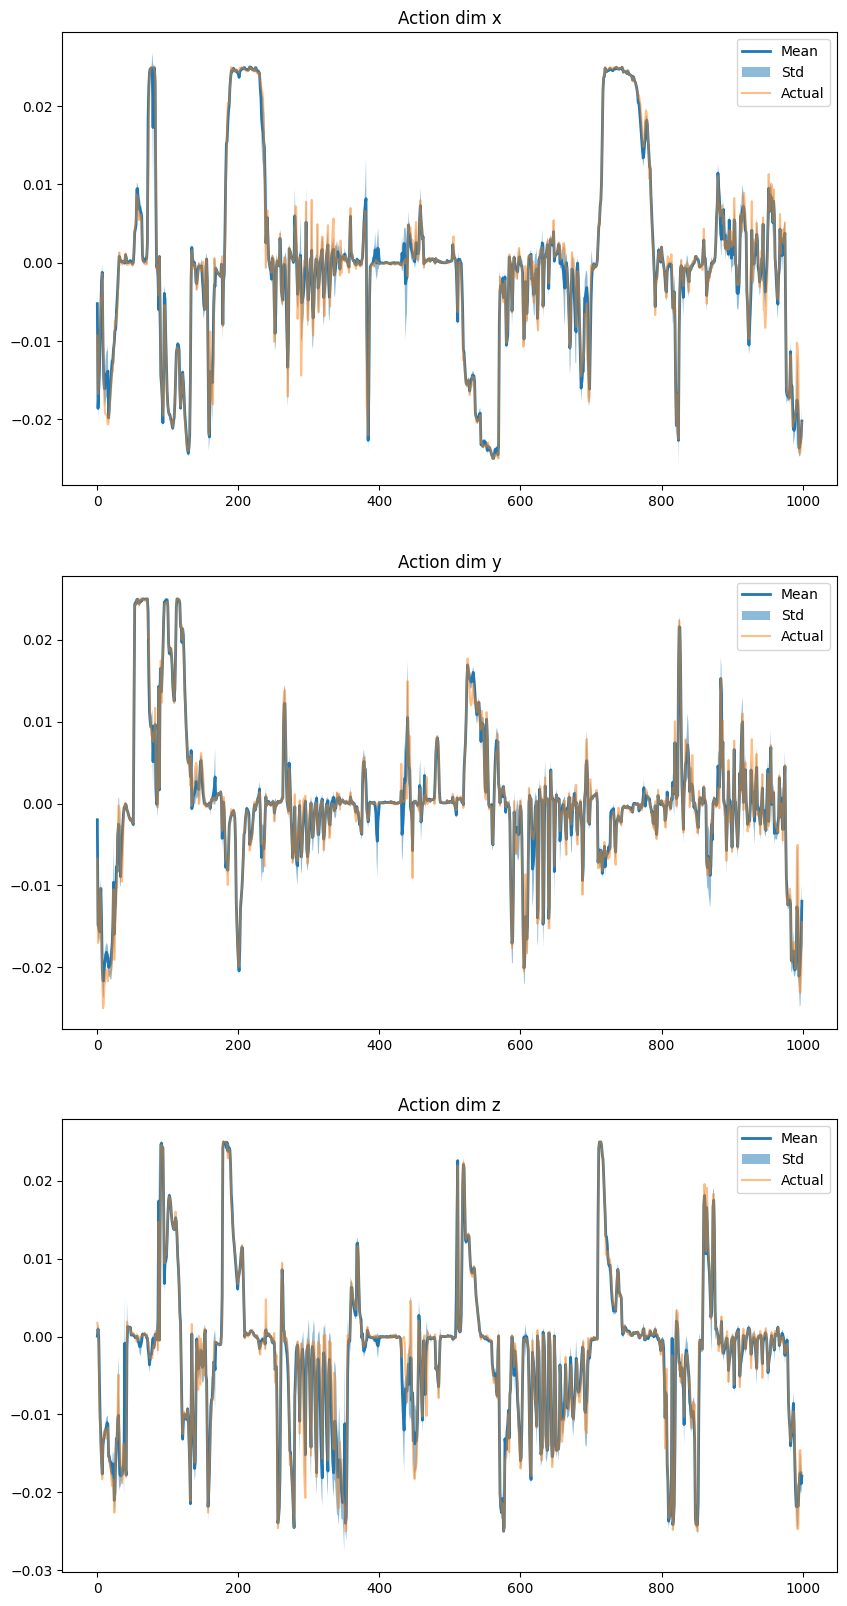

In [28]:
plot_episode(means, stds, actuals, insertion_idx)